In [4]:
import matplotlib.colors as colors
# %matplotlib qt  # or %matplotlib tk
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import gsw
import math
import scipy.io
import cmocean 
import sys
sys.path.insert(1, '/Users/emmagurcan/Documents/France/ENS/M1/stageM1/analysis')
from functions_MSM74 import *
import fonctions as f
import matplotlib.ticker as ticker
import netCDF4 as nc
import cartopy.crs as ccrs
import gsw
from scipy.spatial import cKDTree
from scipy import interpolate
from scipy.interpolate import griddata
from matplotlib.colors import Normalize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cmocean
import numpy as np
from scipy.signal import find_peaks
from matplotlib.colors import ListedColormap
from scipy.ndimage import label

In [5]:
def  plot_ts_diagrams_anom_all_eddies(anomalyt, anomalys, xs, zs, t_grid, s_grid, sigma_grid, distance, depth, ind_Z, cruise, section_num, sub_section=None, ylimmax = 4, ylimmin = 3, xlimmax = 35, xlimmin = 34, inv_x=0, cmap='coolwarm', clabel="Celsius"):
    original_cmap1 = plt.cm.Reds
    # cmap1 = colors.ListedColormap(original_cmap1(np.linspace(0.4, 1, 256)))
    col = ["blue", "orange", "green", "red", "purple", "brown"]
    original_cmap2 = plt.cm.Blues
    cmap2 = colors.ListedColormap(original_cmap2(np.linspace(0.4, 1, 256)))
    # Create subplots (3 subplots now: eddy plot, TS diagram with color maps, TS diagram with red/blue colors)
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    ax1 = axes[0]
    eddy_dict = get_eddies(section_num, cruise, sub_section=sub_section)
    store_data = {}
    for eddy_num in eddy_dict:
        eddy_center_x, eddy_center_z, a, b = eddy_dict[eddy_num]
        eddy_center = (eddy_center_x , eddy_center_z)
        if eddy_num == 10 or eddy_num ==20:
            min1 = np.nanmin(anomalyt)
            n2 = Normalize(vmin=min1, vmax=-1 * min1)
            contour = ax1.contourf(np.unique(distance), -1*ind_Z, 0.5*anomalyt, cmap='coolwarm',
                                        levels=np.linspace(min1, -1 * min1, 101), norm=n2, extend='both')
            # contour = ax1.contourf(distance, -1*ind_Z, anomalyt, cmap='coolwarm',
            #                             levels=np.linspace(min1, -1 * min1, 101), norm=n2, extend='both')

            temp_eddy_3d, temp_eddy, sal_eddy, dens_eddy, zs_eddy, temp_other, sal_other, dens_other, zs_other  = extract_eddy_data_ellip(xs, ind_Z, t_grid, s_grid, sigma_grid, eddy_center, a, b)
            x0, z0 = eddy_center
            theta = np.linspace(0, 2 * np.pi, 100)
            ellipsoid_x = x0 + a * np.cos(theta)
            ellipsoid_z = z0 + b * np.sin(theta)
            ax1.plot(ellipsoid_x, ellipsoid_z, color=col[eddy_num], linewidth=2, zorder=10)
            plot_eddy_ellip(ax1, xs, zs, temp_eddy_3d, col[eddy_num], sigma_grid, f"Eddy in {cruise} Section {section_num}", "Celsius", "cmo.thermal", eddy_center, a, b, cruise, inv_x=inv_x)
        else:
            temp_eddy_3d, temp_eddy, sal_eddy, dens_eddy, zs_eddy, temp_other, sal_other, dens_other, zs_other = extract_eddy_data_anom(anomalyt, t_grid, s_grid, sigma_grid, xs, ind_Z, eddy_center, a, b)
            plot_eddy_selected(ax1, xs, zs, 0.5*anomalyt, temp_eddy_3d, sigma_grid, distance, ind_Z, f"Eddies in {cruise} Section {section_num}", clabel, col[eddy_num], cruise, section_num, depth, inv_x=inv_x)

        store_data[eddy_num] = (sal_eddy, temp_eddy, zs_eddy, sal_other, temp_other, zs_other)
  
                    
    contour_levels = np.arange(23, 28, 0.2)
    clines = ax1.contour(xs, zs, sigma_grid, levels=contour_levels, colors='k', linewidths=0.8)
    ax1.clabel(clines, inline=True, fmt='%1.1f', fontsize=11)
    ax1.set_ylim(0, 300)
    ax1.invert_yaxis()
    # Plot 2: TS Diagram with color maps
    ax2 = axes[1]
    # possibles de S
    SAL_diag = np.arange(0, 37, 0.01)
    TEMP_diag = np.arange(-3, 20, 0.1)
    SAL_diag, TEMP_diag = np.meshgrid(SAL_diag, TEMP_diag)
    SIGMA0_diag = gsw.density.sigma0(SAL_diag, TEMP_diag)
    Contourrange = np.arange(21, 38, 0.1)

    CS = ax2.contour(SAL_diag, TEMP_diag, SIGMA0_diag, Contourrange, colors='k', linestyles=':', zorder=1)

    ax2.clabel(CS, fontsize=11, inline=False)

    for eddy_num in store_data:
        sal_eddy, temp_eddy, zs_eddy, sal_other, temp_other, zs_other = store_data[eddy_num]

        sc1 = ax2.scatter(sal_eddy, temp_eddy, c=col[eddy_num], marker='.', zorder=10)  # Intérieur (core of the eddy in red)
        sc2 = ax2.scatter(sal_other, temp_other, c=zs_other, marker='.', cmap=cmap2)  # Extérieur gauche (reference profile in blue)

    cb2 = plt.colorbar(sc2, ax=ax2)
    cb2.set_label('Reference Profile Depth [m]')

    # cb1.ax.invert_yaxis()
    cb2.ax.invert_yaxis()


    water_masses = {
        "LSW" : (3.2, 0.7, 34.85, 0.1, 'orange'),
        "SAIW": (3.62, 0.43, 34.994, 0.057, 'coral'),
        # "MW" : (12, 0.5, 36.3, 0.2, 'darkgreen'),
        "NEADW" : (3.5, 0.5, 35.7, 0.2, 'green'),
        "AABW" : (-0.5, 0.5, 34.63, 0.2, 'magenta'),
        # "EDW": (18, 0.5, 36.5, 0.2, 'darkcyan'),
        "IBW": (7.5, 0.5, 35.125, 0.02, 'crimson'),
        "RTW": (7.7, 0.3, 35.2, 0.02, 'indigo'),
    }

    dens_water_masses = {
        "SPMW27.3" : (9.82, 0.8, 35.41, 0.083, 27.3, 0.05, 'darkblue'),
        "SPMW27.4" : (8.64, 0.8, 35.29, 0.04, 27.4, 0.05, 'darkblue'),
        "SPMW27.5" : (7.53, 0.5, 35.2, 0.09, 27.5, 0.05, 'darkblue'),
        "DSOW" : (0.17, 1, 34.66, 0.08, 27.82, 0.05, 'darkgoldenrod'),
        "AAIW" : (4, 0.5, 34.2, 0.1, 27.1, 0.05, 'blue'),
        "ISOW" : (1.25, 1.75, 34.885, 0.015, 27.9, 0.1, 'purple'),
        # "ISW": (3.4, 0.2, 35.02, 0.1, 27.74, 0.05, 'lightpink')
    }

    if section_num == 4 and cruise == 'MSM40':
        water_masses["S4"] = (3.604, 1.680, 33.934, 0.709, 'darkgreen')

    sal_min = float("inf")
    sal_max = float("-inf")
    temp_min = float("inf")
    temp_max = float("-inf")

    for eddy_num, (sal_eddy, temp_eddy, _, _, _, _) in store_data.items():
        sal_min = min(sal_min, np.nanmin(sal_eddy))
        sal_max = max(sal_max, np.nanmax(sal_eddy))
        temp_min = min(temp_min, np.nanmin(temp_eddy))
        temp_max = max(temp_max, np.nanmax(temp_eddy))


    ymin = temp_min - 1
    ymax = temp_max + 1
    xmin = sal_min - 0.1
    xmax = sal_max + 0.1

    for name, (temp_mean, temp_std, sal_mean, sal_std, color) in water_masses.items():
        if np.nanmin(temp_mean) > ymin and np.nanmax(temp_mean) < ymax and np.nanmin(sal_mean) > xmin and np.nanmax(sal_mean) < xmax:
            ax2.fill_betweenx(
                [temp_mean - temp_std, temp_mean + temp_std],
                sal_mean - sal_std, sal_mean + sal_std,
                color=color, alpha=0.3, label=name, zorder=10
            )
            ax2.text(sal_mean, temp_mean, name, fontsize=9, ha='center', va='center', color='black', fontweight='bold', zorder=10)


    # Highlight only the specific regions along density contours for dens_water_masses
    for name, (temp_mean, temp_std, sal_mean, sal_std, density, density_std, color) in dens_water_masses.items():
    # Find the closest contour level to the given density
        if np.nanmin(temp_mean) > ymin and np.nanmax(temp_mean) < ymax and np.nanmin(sal_mean) > xmin and np.nanmax(sal_mean) < xmax:
            density_levels = np.array(CS.levels)  # Extract contour levels
            closest_level = density_levels[np.abs(density_levels - density).argmin()]  # Find closest contour

            # Get contour paths corresponding to the closest density level
            for path in CS.collections[np.where(density_levels == closest_level)[0][0]].get_paths():
                vertices = path.vertices
                salinity_contour, temperature_contour = vertices[:, 0], vertices[:, 1]

                # Find the part of the contour that is within the salinity and temperature range
                mask = (
                    (temperature_contour >= temp_mean - temp_std) & (temperature_contour <= temp_mean + temp_std) &
                    (salinity_contour >= sal_mean - sal_std) & (salinity_contour <= sal_mean + sal_std)
                )

                # Highlight only the selected part of the contour
                if np.any(mask):
                    ax2.fill_betweenx(
                        temperature_contour[mask],
                        salinity_contour[mask] - sal_std,
                        salinity_contour[mask] + sal_std,
                        color=color, alpha=0.3, label=name, zorder=10
                    )

                    # Compute the midpoint for better label placement
                    avg_sal = np.mean(salinity_contour[mask])
                    avg_temp = np.mean(temperature_contour[mask])

                    # Place the label slightly above the highlighted region
                    ax2.text(
                        avg_sal, avg_temp + 0.2,  # Shift label slightly upwards
                        name, fontsize=9, ha='center', va='bottom', color='black', fontweight='bold', zorder=10
                    )

 
    # Labels and title
    ax2.set_xlabel(r'$ {\rm Salinity \,  [} {\rm psu]}$', fontsize=15, rasterized=True)
    ax2.set_ylabel(r'$ {\rm Temperature \,  [} {\rm °C]}$', fontsize=15, rasterized=True)
    ax2.set_title(r'$\theta-S$ diagram', fontsize=20)
    # xmin = 34.5
    # xmax = 35.4
    # ymin = 2
    # ymax=5
    ax2.set_ylim(ymin, ymax)
    ax2.set_xlim(xmin, xmax)

    # Add legends
    ax2.legend(loc='lower right', fontsize='small')
    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax2.tick_params(axis='both', which='major', labelsize=13)

    # Adjust layout and show the plot
    plt.tight_layout()
    # plt.savefig(f"/Users/emmagurcan/Documents/France/ENS/M1/stageM1/analysis/plots/{cruise}/ts/section_{section_num}_eddy_{eddy_num}")
    plt.show()

def plot_eddy_selected(ax, xs, zs, anomalyt, temp_eddy, sigma_grid, distance, ind_Z, title, cbar_label, c, cruise, section_num, depth, cmap=None, ylimmax=300, inv_x=0):
    # if ylimmax is None:
    #     ylimmax = np.max(zs)
    
    X, Z = np.meshgrid(xs, zs)
    if cruise == "MSM74":
        min1 = np.nanmin(anomalyt)
        n2 = Normalize(vmin=min1, vmax=-1 * min1)
        # contour = ax.contourf(np.unique(distance), -1*ind_Z, anomalyt, cmap='coolwarm',
        #                             levels=np.linspace(min1, -1 * min1, 101), norm=n2, extend='both')
        contour = ax.contourf(distance, -1*ind_Z, anomalyt, cmap='coolwarm',
                                    levels=np.linspace(min1, -1 * min1, 101), norm=n2, extend='both')
            
        # ax.colorbar(contour)
        contour_levels = np.arange(23, 28, 0.2)
        clines = ax.contour(xs, zs, sigma_grid, levels=contour_levels, colors='k', linewidths=0.8)
        # ax.clabel(clines, inline=True, fmt='%1.1f', fontsize=11)
        # plt.ylim(0, -500)
        # plt.gca().invert_yaxis()

    else:
        min1 = 0.5* np.nanmin(anomalyt)
        n2 = Normalize(vmin=min1, vmax=-1 * min1)
        contour = ax.contourf(np.unique(distance), -1*ind_Z, 0.5*anomalyt, cmap='coolwarm',
                                levels=np.linspace(min1, -1 * min1, 101), norm=n2, extend='both')
           
        # contour_levels = np.arange(23, 28, 0.2)

        # clines = ax.contour(X, Z, sigma_grid, levels=contour_levels, colors='k', linewidths=0.8)
        
    # plt.colorbar(contour)
    if c == "orange":
        cbar = plt.colorbar(contour, ax=ax)
        cbar.set_label(cbar_label)
        cbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    

    # Highlight temp_eddy in green
    # Create a binary mask where temp_eddy has values (non-NaN)
    masked_eddy = np.where(~np.isnan(temp_eddy), 1, np.nan)

    # Convert to boolean mask
    mask = ~np.isnan(masked_eddy)

    # (Optional) Slight dilation to connect small gaps
    mask_dilated = scipy.ndimage.binary_dilation(mask)

    # Convert to float (1 where eddy exists, 0 elsewhere)
    mask_float = mask_dilated.astype(float)

    ax.contour(xs, -1 * ind_Z, mask_float, levels=[0.5], colors=c, linewidths=2, zorder=11)
    # highlight = ax.pcolormesh(xs, -1*ind_Z, temp_eddy, cmap=c, shading='auto', alpha=0.22, zorder=10)
        
    firsts = get_dists(distance, depth, section_num, cruise="MSM40")
    ys = np.ones_like(firsts)
    ys = ys * 8
    ax.scatter(firsts, ys, color="red", s=6, zorder=10)
    # ax.clabel(clines, inline=True, fmt='%1.1f', fontsize=11)
    
    ax.set_xlabel("Distance [km]", fontsize=15)
    ax.set_ylabel("Depth [m]", fontsize=15)
    ax.set_title(title, fontsize=20)
    ax.set_ylim(0, 500)
    ax.invert_yaxis()
    
    if inv_x:
        ax.invert_xaxis()
        
def get_eddies(section_num, cruise, sub_section=None):
    if cruise == "MSM74":
        if section_num == 2:
            eddies = {1: (50, 220, 20, 120), 2: (219, 210, 60, 90), 3: (369, 120, 20, 90)}
            return eddies
        if section_num == 3:
            eddies = {1: (230, 230, 90, 210)}
            return eddies
        if section_num == 4:
            print(f"No eddies in {cruise} section {section_num}")
            return None
        if section_num == 5:
            eddies = {1: (80, 120, 8, 50), 2: (165, 115, 29, 60)}
            return eddies
        if section_num == 6:
            print(f"No eddies in {cruise} section {section_num}")
            return None
        if section_num == 7:
            eddies = {1: (115, 280, 10, 150), 2: (200, 100, 10, 60), 3: (268, 190, 10, 100)}
            return eddies
    if cruise == "MSM40":
        if section_num == 1:
            eddies = {1: (120, 40, 20, 40), 2: (180, 20, 10, 20), 3: (270, 25, 70, 30), 4: (400, 70, 70, 180)}
            print(eddies)
            return eddies
        if section_num == 2:
            print(f"No eddies in {cruise} section {section_num}")
            return None
        if section_num == 3:
            eddies = {1: (170, 70, 30, 50), 2: (375, 45, 9, 22)}
            return eddies
        if section_num == 4:
            eddies = {1: (45, 125, 25, 100), 2: (120, 125, 16, 100), 3: (250, 130, 30, 120)}
            return eddies
        if section_num == 5:
            if sub_section == 1:
                eddies = {1: (65, 115, 45, 150),  2: (250, 145, 10, 115), 3: (315, 75, 9, 49), 4: (410, 150, 50, 140)} 
                return eddies
            if sub_section == 2:
                eddies = {1: (80, 50, 20, 39), 2: (275, 40, 40, 90)}
                return eddies
        if section_num == 6:
            print(f"No eddies in {cruise} section {section_num}")
            return None
        if section_num == 7:
            if sub_section == 3:
                eddies = {1: (75, 75, 25, 100), 2: (137, 70, 10, 45), 3: (272, 120, 25,90)}
            if sub_section == 2:
                eddies = {1: (25, 65, 14, 20), 2: (180, 90, 12, 55), 3: (260, 70, 18, 30), 4: (335, 120, 40, 90)}
                return eddies
            if sub_section == 1:
                eddies = {1: (50, 165, 30, 140), 2: (150, 200, 30, 140), 3: (325, 160, 30, 140)}
            return eddies 

def create_ref_profile(var_grid, distance, lon, lat, x_min, x_max):
    sel_idxs = np.where((distance < x_max) & (distance > x_min))
    lons = lon[sel_idxs].squeeze()
    lats = lat[sel_idxs].squeeze()
    ref_profile = var_grid[:, sel_idxs].squeeze()
    # plt.contourf(ref_profile)
    # plt.ylim(0, 300)
    # plt.gca().invert_yaxis()
    
    return np.mean(ref_profile, axis=1), np.mean(lons), np.mean(lats)

def extract_eddy_data_anom1(temp_anomaly, temperature, salinity, density, xs, zs, eddy_center, a, b, ind_Z):
    X, Z = np.meshgrid(xs, -1*ind_Z)
    print(ind_Z)
    x0, z0 = eddy_center
    
    # Initial ellipsoid mask for eddy range
    ellipsoid_mask = ((X - x0)**2 / a**2 + (Z - z0)**2 / b**2) <= 1

    # Extract anomaly values within the initial eddy range
    temp_anomaly_eddy = np.where(ellipsoid_mask, temp_anomaly, np.nan)

    # max_anomaly = temp_anomaly_eddy[np.unravel_index(np.nanargmax(np.abs(temp_anomaly_eddy)), temp_anomaly_eddy.shape)]
    max_anomaly_idx = np.unravel_index(np.nanargmax(np.abs(temp_anomaly_eddy)), temp_anomaly_eddy.shape)
    max_anomaly = temp_anomaly_eddy[max_anomaly_idx]
    print("Max Anomaly:", max_anomaly, "at index:", max_anomaly_idx)


    if max_anomaly < 0:
        eddy_mask = ellipsoid_mask & (temp_anomaly_eddy <= (0.25 * max_anomaly))
    else:
        eddy_mask = ellipsoid_mask & (temp_anomaly_eddy >= (0.25 * max_anomaly))



    # Extract eddy properties based on refined eddy mask
    temp_eddy = np.where(eddy_mask, temperature, np.nan)
    sal_eddy = np.where(eddy_mask, salinity, np.nan)
    dens_eddy = np.where(eddy_mask, density, np.nan)
    zs_eddy = np.where(eddy_mask, Z, np.nan)
    
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipsoid_x = x0 + a * np.cos(theta)
    ellipsoid_z = z0 + b * np.sin(theta)
    
    # Ensure the ellipsoid is within the depth bounds
    levels = np.linspace(-2, 2, 50)
    plt.contourf(xs, -1* ind_Z, temp_anomaly, cmap='coolwarm', levels=levels, extend='both')
    plt.pcolormesh(xs, -1 * ind_Z, temp_anomaly_eddy, cmap=ListedColormap(['orange']))
    plt.plot(ellipsoid_x, ellipsoid_z, color='red', linewidth=2, zorder=10)
    plt.ylim(0, 800)
    plt.gca().invert_yaxis()
    plt.show()

    # Extract non-eddy properties
    temp_other = np.where(~eddy_mask, temperature, np.nan)
    sal_other = np.where(~eddy_mask, salinity, np.nan)
    dens_other = np.where(~eddy_mask, density, np.nan)
    zs_other = np.where(~eddy_mask, Z, np.nan)
    
    return (
        temp_eddy, temp_eddy.flatten(), sal_eddy.flatten(), dens_eddy.flatten(), zs_eddy.flatten(),
        temp_other.flatten(), sal_other.flatten(), dens_other.flatten(), zs_other.flatten()
    )

def extract_eddy_data_anom(temp_anomaly, temperature, salinity, density, xs, ind_Z, eddy_center, a, b):
    X, Z = np.meshgrid(xs, -1*ind_Z)
    x0, z0 = eddy_center
    
    # Initial ellipsoid mask for eddy range
    ellipsoid_mask = ((X - x0)**2 / a**2 + (Z - z0)**2 / b**2) <= 1

    # Extract anomaly values within the initial eddy range
    temp_anomaly_eddy = np.where(ellipsoid_mask, temp_anomaly, np.nan)
  
    # Find the maximum anomaly value and its location
    max_anomaly = temp_anomaly_eddy[np.unravel_index(np.nanargmax(np.abs(temp_anomaly_eddy)), temp_anomaly_eddy.shape)]
    print(max_anomaly)
    # max_anomaly = np.nanmax(temp_anomaly_eddy)

    # Create a binary mask for regions above 50% of the peak anomaly
    if max_anomaly < 0:
        eddy_mask = ellipsoid_mask & (temp_anomaly <= (0.25 * max_anomaly))
    else:
        eddy_mask = ellipsoid_mask & (temp_anomaly >= (0.25 * max_anomaly))

    # Extract eddy properties based on refined eddy mask
    temp_eddy = np.where(eddy_mask, temperature, np.nan)
    sal_eddy = np.where(eddy_mask, salinity, np.nan)
    dens_eddy = np.where(eddy_mask, density, np.nan)
    zs_eddy = np.where(eddy_mask, Z, np.nan)
    
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipsoid_x = x0 + a * np.cos(theta)
    ellipsoid_z = z0 + b * np.sin(theta)
    
    # Ensure the ellipsoid is within the depth bounds
    # Extract non-eddy properties
    temp_other = np.where(~eddy_mask, temperature, np.nan)
    sal_other = np.where(~eddy_mask, salinity, np.nan)
    dens_other = np.where(~eddy_mask, density, np.nan)
    zs_other = np.where(~eddy_mask, Z, np.nan)
    
    return (
        temp_eddy, temp_eddy.flatten(), sal_eddy.flatten(), dens_eddy.flatten(), zs_eddy.flatten(),
        temp_other.flatten(), sal_other.flatten(), dens_other.flatten(), zs_other.flatten()
    )
def extract_eddy_data_ellip(xs, zs, temperature, salinity, density, eddy_center, a, b):
    X, Z = np.meshgrid(xs, -1*zs)
    x0, z0 = eddy_center
    ellipsoid_mask = ((X - x0)**2 / a**2 + (Z - z0)**2 / b**2) <= 1
    temp_eddy = np.where(ellipsoid_mask, temperature, np.nan)
    sal_eddy = np.where(ellipsoid_mask, salinity, np.nan)
    dens_eddy = np.where(ellipsoid_mask, density, np.nan)
    zs_eddy = np.where(ellipsoid_mask, Z, np.nan)

    temp_other = np.where(~ellipsoid_mask, temperature, np.nan)
    sal_other = np.where(~ellipsoid_mask, salinity, np.nan)
    dens_other = np.where(~ellipsoid_mask, density, np.nan)
    zs_other = np.where(~ellipsoid_mask, Z, np.nan)
    
    return temp_eddy, temp_eddy.flatten(), sal_eddy.flatten(), dens_eddy.flatten(), zs_eddy.flatten(), temp_other.flatten(), sal_other.flatten(), dens_other.flatten(), zs_other.flatten()


In [6]:
woa_salinity_path = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/august/2015-2022_mean/woa23_decav_s08_01.nc"
woa_path = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/august/2015-2022_mean/woa23_B5C2_t08_01.nc"
raw_ctd = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/raw_ctd.nc"
ds_clean = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/clean_ctd.nc"
clean_lonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/clean_lonlatev.nc"
nclonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_lonlat.nc"
readcp = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74-VMADCP_allfiles/msm_074_1_vmadcp_75khz_01.nc"
rep = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_CTD.tab"
lon_lat_event = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/lon_lat_event.nc"
rep = '/Users/emmagurcan/Documents/France/ENS/M1/stageM1'
uCTD = scipy.io.loadmat(rep+'/Data/Data_MSM40/UCTD_dataproc.mat')
adcp = scipy.io.loadmat(rep +'/Data/Data_MSM40/adcp_150kHz/TL_GEOMAR_150_STJOHNS_BREST_000_000000_6_hc.mat')

In [7]:
ds_adcp = nc.Dataset(readcp)
ds_ctd = nc.Dataset(ds_clean)
lonlatev = nc.Dataset(clean_lonlat)
ds = nc.Dataset(woa_path)
dss = nc.Dataset(woa_salinity_path)
cruise = "MSM74"
set_maxdepth(cruise)

In [8]:
section_num = 3
sub_section = 1

if cruise == "MSM74":
    times, press, depth, T, S, lon, lat, inv_x, lat_adcp_section, lon_adcp_section, depth_adcp, u_adcp, v_adcp = load_data(section_num, lonlatev, ds_ctd, ds_adcp)
    distance = determine_distance(lon, lat, inv_x, section_num)
    
    distance_adcp = determine_distance(lon_adcp_section, lat_adcp_section, inv_x, section_num)
    v_ortho = calc_ortho_vel(section_num, cruise, lon_adcp_section, lat_adcp_section, u_adcp, v_adcp)
    mdepth = get_maxdepth()
    distance, depth, v_ortho, lon_adcp_section, lat_adcp_section, distance_adcp, times, press, depth, T, S, lon, lat = snip_data(distance, depth, section_num, v_ortho, lon_adcp_section, lat_adcp_section, distance_adcp, times, press, depth, T, S, lon, lat)
   
    if section_num == 1:
        distance_adcp = np.linspace(np.min(distance), np.max(distance), len(distance_adcp))

    sigma0 = determine_sigma(S, T, press, lon, lat)
    SA = gsw.SA_from_SP(S, press, lon, lat)  # Longitude and Latitude needed
    CT = gsw.CT_from_t(SA, T, press)
    mdepth = get_maxdepth()
    ndepth = get_numdepth()

    CT = make_3D(distance, depth, CT, section_num, cruise)
    SA = make_3D(distance, depth, SA, section_num, cruise)
    sigma_grid = make_3D(distance, depth, sigma0, section_num, cruise)


    if section_num == 5:
        indices = find_increasing_intervals(depth)
        xs = np.array([distance[s] for s, st in indices])
        print(len(xs))
    else:
        xs = np.unique(distance)
        
    print(mdepth)
    depth = np.linspace(0, mdepth, ndepth)
    zs = depth
    distance = xs
    
    yl = 800

    
else:
    # Define the section (section 2 can't be plotted => no uCTD measures)
    start_index, end_index, len_section, start_index_adcp, end_index_adcp = f.section(section_num)
    name = f'section_{section_num}'
    inv_x = 0
    
    # Define depth limit for uCTD
    depth_max=300

    # Define depth limit for ADCP
    depth_max_adcp=300

    # Create depth array
    depth = np.arange(0, 1001)

    # CTD data
    lon = np.squeeze(uCTD['uctdlon'])[start_index:end_index+1]
    lat = np.squeeze(uCTD['uctdlat'])[start_index:end_index+1]
    T = np.squeeze(uCTD['Tgrid'])[:,start_index:end_index+1]
    PD = np.squeeze(uCTD['PDgrid'])[:,start_index:end_index+1]
    S = np.squeeze(uCTD['Sgrid'])[:,start_index:end_index+1]
    press = uCTD['pressure']
    

    # Select adcp data
    b = adcp['b']
    bb = b[0,0]
    ref = bb[0][0,0][0]
    nav = bb[2][0,0][0]
    vel = bb[1]
    u = vel[:,0,:] + ref[0,:] # vitesse zonale, positive vers l'est
    v = vel[:,1,:] + ref[1,:] # vitesse méridionale, positive vers le nord
    depth_adcp = bb[3][0]
    LON_adcp = nav[1,:]
    LAT_adcp = nav[2,:]
    LAT = LAT_adcp[start_index_adcp:end_index_adcp+1]
    LON = LON_adcp[start_index_adcp:end_index_adcp+1]
    u_section = u[:,start_index_adcp:end_index_adcp+1]
    v_section = v[:,start_index_adcp:end_index_adcp+1]

    if section_num == 5:
        splits = [-45.168683, -53.5, -60.0843339]
        start = splits[sub_section - 1]
        stop = splits[sub_section]
        valid_ctd = np.where(np.logical_and(lon < start, lon > stop))
        lon = lon[valid_ctd]
        lat = lat[valid_ctd]
        T = T[:, valid_ctd].squeeze()
        PD = PD[:, valid_ctd].squeeze()
        S = S[:, valid_ctd].squeeze()
        valid_adcp = np.where(np.logical_and(LON < start, LON > stop))
        LAT = LAT[valid_adcp]
        LON = LON[valid_adcp]
        u_section = u_section[:, valid_adcp].squeeze()
        v_section = v_section[:, valid_adcp].squeeze() 

    if section_num == 7:
        splits = np.linspace(np.max(lon), np.min(lon), 4)
        start = splits[sub_section - 1]
        stop = splits[sub_section]
        valid_ctd = np.where(np.logical_and(lon < start, lon > stop))
        lon = lon[valid_ctd]
        lat = lat[valid_ctd]
        T = T[:, valid_ctd].squeeze()
        PD = PD[:, valid_ctd].squeeze()
        S = S[:, valid_ctd].squeeze()
        valid_adcp = np.where(np.logical_and(LON < start, LON > stop))
        LAT = LAT[valid_adcp]
        LON = LON[valid_adcp]
        u_section = u_section[:, valid_adcp].squeeze()
        v_section = v_section[:, valid_adcp].squeeze()

    d1 = np.sin(lat*(math.pi/180))*np.sin(lat[0]*(math.pi/180))
    d2 = np.cos(lat*(math.pi/180))*np.cos(lat[0]*(math.pi/180)) * \
        np.cos(abs(lon[0]-lon)*(math.pi/180))
    distance = 6371*np.arccos(d1+d2)

    d1_adcp = np.sin(LAT*(math.pi/180))*np.sin(LAT[0]*(math.pi/180))
    d2_adcp = np.cos(LAT*(math.pi/180))*np.cos(LAT[0]*(math.pi/180)) * \
        np.cos(abs(LON[0]-LON)*(math.pi/180))
    distance_adcp = 6371*np.arccos(d1_adcp+d2_adcp)

    v_ortho = calc_ortho_vel(section_num, cruise, LON, LAT, u_section, v_section)
    mdepth = get_maxdepth()
    ndepth = get_numdepth()

    sigma_grid = PD
    s_grid = S
    t_grid = T

    SA = gsw.SA_from_SP(S, press, lon, lat)  # Longitude and Latitude needed
    CT = gsw.CT_from_t(SA, T, press)

    xs = distance
    zs = depth
    yl = 300

800


In [9]:
# # Reference profile
# lon_woa = ds['lon']
# lat_woa = ds['lat']
# # t_an = np.squeeze(ds['t_an'])
# # t_an14 = np.squeeze(ds['t_an'])
# t_mn = np.squeeze(dss['s_mn'])
# s_mn = np.squeeze(ds['t_mn'])
# depth_ref = np.squeeze(ds['depth'])
# print(lon_woa.shape)
# # print(t_an.shape)
# sref, lon_sel, lat_sel = get_woa_ref(lon, lat, lon_woa, lat_woa, t_mn)
# tref, lon_woa_sels, lat_woa_sels = get_woa_ref(lon, lat, lon_woa, lat_woa, s_mn)
# inf_mask = np.where(tref == 9.9692100e+36)
# tref[inf_mask] = np.nan

# inf_mask = np.where(sref == 9.9692100e+36)
# sref[inf_mask] = np.nan


tref, lon_sel, lat_sel = create_ref_profile(CT, distance, lon, lat, 200, 400)
sref, lon_sel, lat_sel = create_ref_profile(SA, distance, lon, lat, 200, 400)
depth_ref = depth

In [10]:
anomalyt, ind_X, ind_Z = anom(tref, sref, lon_sel, lat_sel, depth_ref, CT, SA, sigma_grid, distance, "temperature")
anomalys, ind_X, ind_Z = anom(tref, sref, lon_sel, lat_sel, depth_ref, CT, SA, sigma_grid, distance, "salinity")
anomalyp, ind_X, ind_Z = anom(tref, sref, lon_sel, lat_sel, depth_ref, CT, SA, sigma_grid, distance, "density")

Calculating Temperature Anomalies
Calculating Salinity Anomalies
Calculating Density Anomalies
800.0
0.0


In [11]:
eddy_lon = []
eddy_lat = []
other_lons = []
other_lats =[ ]
eddy_dict = get_eddies(section_num, cruise, sub_section=sub_section)
for e in eddy_dict:
    eddy_center_x, eddy_center_z, a, b = eddy_dict[e]
    print(eddy_center_x)
    # eddy_center = (eddy_center_x , eddy_center_z)
    temp_eddy_3d, temp_eddy, sal_eddy, dens_eddy, zs_eddy, temp_other, sal_other, dens_other, zs_other = extract_eddy_data_anom1(anomalyt, CT, SA, sigma_grid, xs, zs, eddy_center, a, b, ind_Z)
    valid_indices = np.where(np.any(~np.isnan(temp_eddy_3d), axis=0))[0]
    eddy_lon.append(lons_unique[valid_indices])
    eddy_lat.append(lats_unique[valid_indices])
    print(valid_indices)
    print(distance[valid_indices])

230


NameError: name 'eddy_center' is not defined

800
(360,)
Calculating Temperature Anomalies
Calculating Salinity Anomalies
Calculating Density Anomalies
800.0
0.0
-0.28039812116743135
-0.4548756726864694
-0.6536165694521409


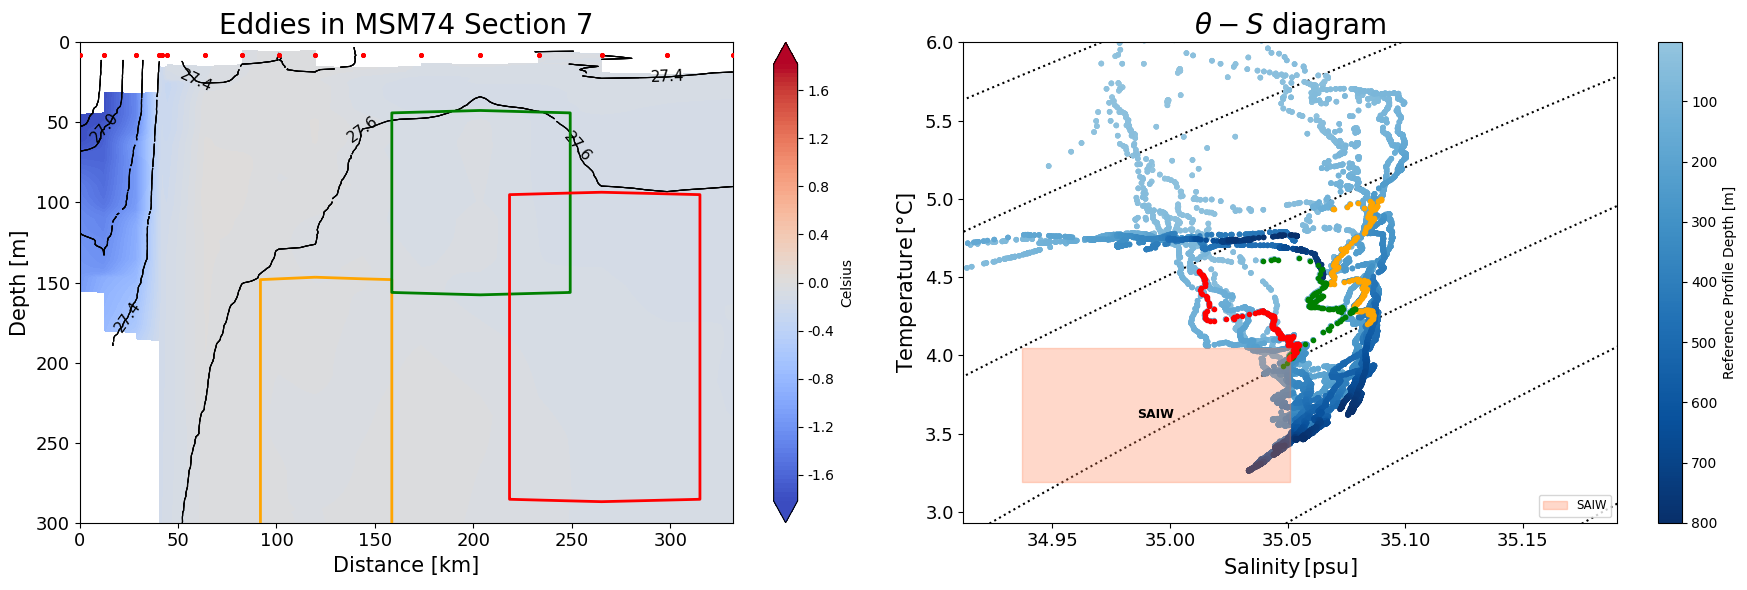

In [12]:
import matplotlib.colors as colors
# %matplotlib qt  # or %matplotlib tk
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import gsw
import math
import scipy.io
import cmocean 
import sys
sys.path.insert(1, '/Users/emmagurcan/Documents/France/ENS/M1/stageM1/analysis')
from functions_MSM74 import *
import fonctions as f
import matplotlib.ticker as ticker
import netCDF4 as nc
import cartopy.crs as ccrs
import gsw
from scipy.spatial import cKDTree
from scipy import interpolate
from scipy.interpolate import griddata
from matplotlib.colors import Normalize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cmocean
import numpy as np
from scipy.signal import find_peaks
from matplotlib.colors import ListedColormap
from scipy.ndimage import label

def  plot_ts_diagrams_anom_all_eddies(anomalyt, anomalys, xs, zs, t_grid, s_grid, sigma_grid, distance, depth, ind_Z, cruise, section_num, sub_section=None, ylimmax = 4, ylimmin = 3, xlimmax = 35, xlimmin = 34, inv_x=0, cmap='coolwarm', clabel="Celsius"):
    original_cmap1 = plt.cm.Reds
    # cmap1 = colors.ListedColormap(original_cmap1(np.linspace(0.4, 1, 256)))
    col = ["blue", "orange", "green", "red", "purple", "brown"]
    original_cmap2 = plt.cm.Blues
    cmap2 = colors.ListedColormap(original_cmap2(np.linspace(0.4, 1, 256)))
    # Create subplots (3 subplots now: eddy plot, TS diagram with color maps, TS diagram with red/blue colors)
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    ax1 = axes[0]
    eddy_dict = get_eddies(section_num, cruise, sub_section=sub_section)
    store_data = {}
    for eddy_num in eddy_dict:
        eddy_center_x, eddy_center_z, a, b = eddy_dict[eddy_num]
        eddy_center = (eddy_center_x , eddy_center_z)
        if eddy_num == 10 or eddy_num ==20:
            min1 = np.nanmin(anomalyt)
            n2 = Normalize(vmin=min1, vmax=-1 * min1)
            contour = ax1.contourf(np.unique(distance), -1*ind_Z, 0.2*anomalyt, cmap='coolwarm',
                                        levels=np.linspace(min1, -1 * min1, 101), norm=n2, extend='both')
            # contour = ax1.contourf(distance, -1*ind_Z, anomalyt, cmap='coolwarm',
            #                             levels=np.linspace(min1, -1 * min1, 101), norm=n2, extend='both')

            temp_eddy_3d, temp_eddy, sal_eddy, dens_eddy, zs_eddy, temp_other, sal_other, dens_other, zs_other  = extract_eddy_data_ellip(xs, ind_Z, t_grid, s_grid, sigma_grid, eddy_center, a, b)
            x0, z0 = eddy_center
            theta = np.linspace(0, 2 * np.pi, 100)
            ellipsoid_x = x0 + a * np.cos(theta)
            ellipsoid_z = z0 + b * np.sin(theta)
            ax1.plot(ellipsoid_x, ellipsoid_z, color=col[eddy_num], linewidth=2, zorder=10)
            plot_eddy_ellip(ax1, xs, zs, temp_eddy_3d, col[eddy_num], sigma_grid, f"Eddy in {cruise} Section {section_num}", "Celsius", "cmo.thermal", eddy_center, a, b, cruise, inv_x=inv_x)
        else:
            temp_eddy_3d, temp_eddy, sal_eddy, dens_eddy, zs_eddy, temp_other, sal_other, dens_other, zs_other = extract_eddy_data_anom(anomalyt, t_grid, s_grid, sigma_grid, xs, ind_Z, eddy_center, a, b)
            plot_eddy_selected(ax1, xs, zs, 0.2*anomalyt, temp_eddy_3d, sigma_grid, distance, ind_Z, f"Eddies in {cruise} Section {section_num}", clabel, col[eddy_num], cruise, section_num, depth, inv_x=inv_x)

        store_data[eddy_num] = (sal_eddy, temp_eddy, zs_eddy, sal_other, temp_other, zs_other)
  
                    
    contour_levels = np.arange(23, 28, 0.2)
    clines = ax1.contour(xs, zs, sigma_grid, levels=contour_levels, colors='k', linewidths=0.8)
    ax1.clabel(clines, inline=True, fmt='%1.1f', fontsize=11)
    ax1.set_ylim(0, 300)
    ax1.invert_yaxis()
    # Plot 2: TS Diagram with color maps
    ax2 = axes[1]
    # possibles de S
    SAL_diag = np.arange(32, 37, 0.01)
    TEMP_diag = np.arange(-3, 20, 0.1)
    SAL_diag, TEMP_diag = np.meshgrid(SAL_diag, TEMP_diag)
    SIGMA0_diag = gsw.density.sigma0(SAL_diag, TEMP_diag)
    Contourrange = np.arange(21, 38, 0.1)

    CS = ax2.contour(SAL_diag, TEMP_diag, SIGMA0_diag, Contourrange, colors='k', linestyles=':', zorder=1)

    ax2.clabel(CS, fontsize=11, manual=False)

    for eddy_num in store_data:
        sal_eddy, temp_eddy, zs_eddy, sal_other, temp_other, zs_other = store_data[eddy_num]

        sc1 = ax2.scatter(sal_eddy, temp_eddy, c=col[eddy_num], marker='.', zorder=10)  # Intérieur (core of the eddy in red)
        sc2 = ax2.scatter(sal_other, temp_other, c=zs_other, marker='.', cmap=cmap2)  # Extérieur gauche (reference profile in blue)

    cb2 = plt.colorbar(sc2, ax=ax2)
    cb2.set_label('Reference Profile Depth [m]')

    # cb1.ax.invert_yaxis()
    cb2.ax.invert_yaxis()


    water_masses = {
        "LSW" : (3.2, 0.7, 34.85, 0.1, 'orange'),
        "SAIW": (3.62, 0.43, 34.994, 0.057, 'coral'),
        # "MW" : (12, 0.5, 36.3, 0.2, 'darkgreen'),
        "NEADW" : (3.5, 0.5, 35.7, 0.2, 'green'),
        "AABW" : (-0.5, 0.5, 34.63, 0.2, 'magenta'),
        # "EDW": (18, 0.5, 36.5, 0.2, 'darkcyan'),
        "IBW": (7.5, 0.5, 35.125, 0.02, 'crimson'),
        "RTW": (7.7, 0.3, 35.2, 0.02, 'indigo'),
    }

    dens_water_masses = {
        "SPMW27.3" : (9.82, 0.8, 35.41, 0.083, 27.3, 0.05, 'darkblue'),
        "SPMW27.4" : (8.64, 0.8, 35.29, 0.04, 27.4, 0.05, 'darkblue'),
        "SPMW27.5" : (7.53, 0.5, 35.2, 0.09, 27.5, 0.05, 'darkblue'),
        "DSOW" : (0.17, 1, 34.66, 0.08, 27.82, 0.05, 'darkgoldenrod'),
        "AAIW" : (4, 0.5, 34.2, 0.1, 27.1, 0.05, 'blue'),
        "ISOW" : (1.25, 1.75, 34.885, 0.015, 27.9, 0.1, 'purple'),
        # "ISW": (3.4, 0.2, 35.02, 0.1, 27.74, 0.05, 'lightpink')
    }

    if section_num == 4 and cruise == 'MSM40':
        water_masses["S4"] = (3.604, 1.680, 33.934, 0.709, 'darkgreen')

    sal_min = float("inf")
    sal_max = float("-inf")
    temp_min = float("inf")
    temp_max = float("-inf")

    for eddy_num, (sal_eddy, temp_eddy, _, _, _, _) in store_data.items():
        sal_min = min(sal_min, np.nanmin(sal_eddy))
        sal_max = max(sal_max, np.nanmax(sal_eddy))
        temp_min = min(temp_min, np.nanmin(temp_eddy))
        temp_max = max(temp_max, np.nanmax(temp_eddy))


    ymin = temp_min - 1
    ymax = temp_max + 1
    xmin = sal_min - 0.1
    xmax = sal_max + 0.1

    for name, (temp_mean, temp_std, sal_mean, sal_std, color) in water_masses.items():
        if np.nanmin(temp_mean) > ymin and np.nanmax(temp_mean) < ymax and np.nanmin(sal_mean) > xmin and np.nanmax(sal_mean) < xmax:
            ax2.fill_betweenx(
                [temp_mean - temp_std, temp_mean + temp_std],
                sal_mean - sal_std, sal_mean + sal_std,
                color=color, alpha=0.3, label=name, zorder=10
            )
            ax2.text(sal_mean, temp_mean, name, fontsize=9, ha='center', va='center', color='black', fontweight='bold', zorder=10)


    # Highlight only the specific regions along density contours for dens_water_masses
    for name, (temp_mean, temp_std, sal_mean, sal_std, density, density_std, color) in dens_water_masses.items():
    # Find the closest contour level to the given density
        if np.nanmin(temp_mean) > ymin and np.nanmax(temp_mean) < ymax and np.nanmin(sal_mean) > xmin and np.nanmax(sal_mean) < xmax:
            density_levels = np.array(CS.levels)  # Extract contour levels
            closest_level = density_levels[np.abs(density_levels - density).argmin()]  # Find closest contour

            # Get contour paths corresponding to the closest density level
            for path in CS.collections[np.where(density_levels == closest_level)[0][0]].get_paths():
                vertices = path.vertices
                salinity_contour, temperature_contour = vertices[:, 0], vertices[:, 1]

                # Find the part of the contour that is within the salinity and temperature range
                mask = (
                    (temperature_contour >= temp_mean - temp_std) & (temperature_contour <= temp_mean + temp_std) &
                    (salinity_contour >= sal_mean - sal_std) & (salinity_contour <= sal_mean + sal_std)
                )

                # Highlight only the selected part of the contour
                if np.any(mask):
                    ax2.fill_betweenx(
                        temperature_contour[mask],
                        salinity_contour[mask] - sal_std,
                        salinity_contour[mask] + sal_std,
                        color=color, alpha=0.3, label=name, zorder=10
                    )

                    # Compute the midpoint for better label placement
                    avg_sal = np.mean(salinity_contour[mask])
                    avg_temp = np.mean(temperature_contour[mask])

                    # Place the label slightly above the highlighted region
                    ax2.text(
                        avg_sal, avg_temp + 0.2,  # Shift label slightly upwards
                        name, fontsize=9, ha='center', va='bottom', color='black', fontweight='bold', zorder=10
                    )

 
    # Labels and title
    ax2.set_xlabel(r'$ {\rm Salinity \,  [} {\rm psu]}$', fontsize=15, rasterized=True)
    ax2.set_ylabel(r'$ {\rm Temperature \,  [} {\rm °C]}$', fontsize=15, rasterized=True)
    ax2.set_title(r'$\theta-S$ diagram', fontsize=20)
    # xmin = 34.5
    # xmax = 35.4
    # ymin = 2
    # ymax=5
    ax2.set_ylim(ymin, ymax)
    ax2.set_xlim(xmin, xmax)

    # Add legends
    ax2.legend(loc='lower right', fontsize='small')
    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax2.tick_params(axis='both', which='major', labelsize=13)

    # Adjust layout and show the plot
    plt.tight_layout()
    # plt.savefig(f"/Users/emmagurcan/Documents/France/ENS/M1/stageM1/analysis/plots/{cruise}/ts/section_{section_num}_eddy_{eddy_num}")
    plt.show()

def plot_eddy_selected(ax, xs, zs, anomalyt, temp_eddy, sigma_grid, distance, ind_Z, title, cbar_label, c, cruise, section_num, depth, cmap=None, ylimmax=300, inv_x=0):
    # if ylimmax is None:
    #     ylimmax = np.max(zs)
    
    X, Z = np.meshgrid(xs, zs)
    if cruise == "MSM74":
        min1 = np.nanmin(anomalyt)
        n2 = Normalize(vmin=min1, vmax=-1 * min1)
        # contour = ax.contourf(np.unique(distance), -1*ind_Z, anomalyt, cmap='coolwarm',
        #                             levels=np.linspace(min1, -1 * min1, 101), norm=n2, extend='both')
        contour = ax.contourf(distance, -1*ind_Z, anomalyt, cmap='coolwarm',
                                    levels=np.linspace(min1, -1 * min1, 101), norm=n2, extend='both')
            
        # ax.colorbar(contour)
        contour_levels = np.arange(23, 28, 0.2)
        clines = ax.contour(xs, zs, sigma_grid, levels=contour_levels, colors='k', linewidths=0.8)
        # ax.clabel(clines, inline=True, fmt='%1.1f', fontsize=11)
        # plt.ylim(0, -500)
        # plt.gca().invert_yaxis()

    else:
        min1 = 0.3* np.nanmin(anomalyt)
        n2 = Normalize(vmin=min1, vmax=-1 * min1)
        contour = ax.contourf(np.unique(distance), -1*ind_Z, 0.2*anomalyt, cmap='coolwarm',
                                levels=np.linspace(min1, -1 * min1, 101), norm=n2, extend='both')
           
        # contour_levels = np.arange(23, 28, 0.2)

        # clines = ax.contour(X, Z, sigma_grid, levels=contour_levels, colors='k', linewidths=0.8)
        
    # plt.colorbar(contour)
    if c == "orange":
        cbar = plt.colorbar(contour, ax=ax)
        cbar.set_label(cbar_label)
        cbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    

    # Highlight temp_eddy in green
    # Create a binary mask where temp_eddy has values (non-NaN)
    masked_eddy = np.where(~np.isnan(temp_eddy), 1, np.nan)

    # Convert to boolean mask
    mask = ~np.isnan(masked_eddy)

    # (Optional) Slight dilation to connect small gaps
    mask_dilated = scipy.ndimage.binary_dilation(mask)

    # Convert to float (1 where eddy exists, 0 elsewhere)
    mask_float = mask_dilated.astype(float)

    ax.contour(xs, -1 * ind_Z, mask_float, levels=[0.5], colors=c, linewidths=2, zorder=11)
    # highlight = ax.pcolormesh(xs, -1*ind_Z, temp_eddy, cmap=c, shading='auto', alpha=0.22, zorder=10)
        
    firsts = get_dists(distance, depth, section_num, cruise="MSM40")
    ys = np.ones_like(firsts)
    ys = ys * 8
    ax.scatter(firsts, ys, color="red", s=6, zorder=10)
    # ax.clabel(clines, inline=True, fmt='%1.1f', fontsize=11)
    
    ax.set_xlabel("Distance [km]", fontsize=15)
    ax.set_ylabel("Depth [m]", fontsize=15)
    ax.set_title(title, fontsize=20)
    ax.set_ylim(0, 500)
    ax.invert_yaxis()
    
    if inv_x:
        ax.invert_xaxis()
        
def get_eddies(section_num, cruise, sub_section=None):
    if cruise == "MSM74":
        if section_num == 2:
            eddies = {1: (50, 220, 20, 120), 2: (219, 210, 60, 90), 3: (369, 120, 20, 90)}
            return eddies
        if section_num == 3:
            eddies = {1: (230, 230, 90, 210)}
            return eddies
        if section_num == 4:
            print(f"No eddies in {cruise} section {section_num}")
            return None
        if section_num == 5:
            eddies = {1: (80, 120, 8, 50), 2: (165, 115, 29, 60)}
            return eddies
        if section_num == 6:
            print(f"No eddies in {cruise} section {section_num}")
            return None
        if section_num == 7:
            eddies = {1: (115, 280, 10, 150), 2: (200, 100, 10, 60), 3: (268, 190, 10, 100)}
            return eddies
    if cruise == "MSM40":
        if section_num == 1:
            eddies = {1: (120, 40, 20, 40), 2: (180, 20, 10, 20), 3: (270, 25, 70, 30), 4: (400, 70, 70, 180)}
            print(eddies)
            return eddies
        if section_num == 2:
            print(f"No eddies in {cruise} section {section_num}")
            return None
        if section_num == 3:
            eddies = {1: (170, 70, 30, 50), 2: (375, 45, 9, 22)}
            return eddies
        if section_num == 4:
            eddies = {1: (45, 125, 25, 100), 2: (120, 125, 16, 100), 3: (250, 130, 30, 120)}
            return eddies
        if section_num == 5:
            if sub_section == 1:
                eddies = {1: (65, 115, 45, 150),  2: (250, 145, 10, 115), 3: (315, 75, 9, 49), 4: (410, 150, 50, 140)} 
                return eddies
            if sub_section == 2:
                eddies = {1: (80, 50, 20, 39), 2: (275, 40, 40, 90)}
                return eddies
        if section_num == 6:
            print(f"No eddies in {cruise} section {section_num}")
            return None
        if section_num == 7:
            if sub_section == 3:
                eddies = {1: (75, 75, 25, 100), 2: (137, 70, 10, 45), 3: (272, 120, 25,90)}
            if sub_section == 2:
                eddies = {1: (25, 65, 14, 20), 2: (180, 90, 12, 55), 3: (260, 70, 18, 30), 4: (335, 120, 40, 90)}
                return eddies
            if sub_section == 1:
                eddies = {1: (50, 165, 30, 140), 2: (150, 200, 30, 140), 3: (325, 160, 30, 140)}
            return eddies 

def create_ref_profile(var_grid, distance, lon, lat, x_min, x_max):
    sel_idxs = np.where((distance < x_max) & (distance > x_min))
    lons = lon[sel_idxs].squeeze()
    lats = lat[sel_idxs].squeeze()
    ref_profile = var_grid[:, sel_idxs].squeeze()
    # plt.contourf(ref_profile)
    # plt.ylim(0, 300)
    # plt.gca().invert_yaxis()
    
    return np.mean(ref_profile, axis=1), np.mean(lons), np.mean(lats)

def extract_eddy_data_anom1(temp_anomaly, temperature, salinity, density, xs, zs, eddy_center, a, b, ind_Z):
    X, Z = np.meshgrid(xs, -1*ind_Z)
    print(ind_Z)
    x0, z0 = eddy_center
    
    # Initial ellipsoid mask for eddy range
    ellipsoid_mask = ((X - x0)**2 / a**2 + (Z - z0)**2 / b**2) <= 1

    # Extract anomaly values within the initial eddy range
    temp_anomaly_eddy = np.where(ellipsoid_mask, temp_anomaly, np.nan)

    # max_anomaly = temp_anomaly_eddy[np.unravel_index(np.nanargmax(np.abs(temp_anomaly_eddy)), temp_anomaly_eddy.shape)]
    max_anomaly_idx = np.unravel_index(np.nanargmax(np.abs(temp_anomaly_eddy)), temp_anomaly_eddy.shape)
    max_anomaly = temp_anomaly_eddy[max_anomaly_idx]
    print("Max Anomaly:", max_anomaly, "at index:", max_anomaly_idx)


    if max_anomaly < 0:
        eddy_mask = ellipsoid_mask & (temp_anomaly_eddy <= (0.25 * max_anomaly))
    else:
        eddy_mask = ellipsoid_mask & (temp_anomaly_eddy >= (0.25 * max_anomaly))



    # Extract eddy properties based on refined eddy mask
    temp_eddy = np.where(eddy_mask, temperature, np.nan)
    sal_eddy = np.where(eddy_mask, salinity, np.nan)
    dens_eddy = np.where(eddy_mask, density, np.nan)
    zs_eddy = np.where(eddy_mask, Z, np.nan)
    
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipsoid_x = x0 + a * np.cos(theta)
    ellipsoid_z = z0 + b * np.sin(theta)
    
    # Ensure the ellipsoid is within the depth bounds
    levels = np.linspace(-2, 2, 50)
    plt.contourf(xs, -1* ind_Z, temp_anomaly, cmap='coolwarm', levels=levels, extend='both')
    plt.pcolormesh(xs, -1 * ind_Z, temp_anomaly_eddy, cmap=ListedColormap(['orange']))
    plt.plot(ellipsoid_x, ellipsoid_z, color='red', linewidth=2, zorder=10)
    plt.ylim(0, 800)
    plt.gca().invert_yaxis()
    plt.show()

    # Extract non-eddy properties
    temp_other = np.where(~eddy_mask, temperature, np.nan)
    sal_other = np.where(~eddy_mask, salinity, np.nan)
    dens_other = np.where(~eddy_mask, density, np.nan)
    zs_other = np.where(~eddy_mask, Z, np.nan)
    
    return (
        temp_eddy, temp_eddy.flatten(), sal_eddy.flatten(), dens_eddy.flatten(), zs_eddy.flatten(),
        temp_other.flatten(), sal_other.flatten(), dens_other.flatten(), zs_other.flatten()
    )

def extract_eddy_data_anom(temp_anomaly, temperature, salinity, density, xs, ind_Z, eddy_center, a, b):
    X, Z = np.meshgrid(xs, -1*ind_Z)
    x0, z0 = eddy_center
    
    # Initial ellipsoid mask for eddy range
    ellipsoid_mask = ((X - x0)**2 / a**2 + (Z - z0)**2 / b**2) <= 1

    # Extract anomaly values within the initial eddy range
    temp_anomaly_eddy = np.where(ellipsoid_mask, temp_anomaly, np.nan)
  
    # Find the maximum anomaly value and its location
    max_anomaly = temp_anomaly_eddy[np.unravel_index(np.nanargmax(np.abs(temp_anomaly_eddy)), temp_anomaly_eddy.shape)]
    print(max_anomaly)
    # max_anomaly = np.nanmax(temp_anomaly_eddy)

    # Create a binary mask for regions above 50% of the peak anomaly
    if max_anomaly < 0:
        eddy_mask = ellipsoid_mask & (temp_anomaly <= (0.25 * max_anomaly))
    else:
        eddy_mask = ellipsoid_mask & (temp_anomaly >= (0.25 * max_anomaly))

    # Extract eddy properties based on refined eddy mask
    temp_eddy = np.where(eddy_mask, temperature, np.nan)
    sal_eddy = np.where(eddy_mask, salinity, np.nan)
    dens_eddy = np.where(eddy_mask, density, np.nan)
    zs_eddy = np.where(eddy_mask, Z, np.nan)
    
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipsoid_x = x0 + a * np.cos(theta)
    ellipsoid_z = z0 + b * np.sin(theta)
    
    # Ensure the ellipsoid is within the depth bounds
    # Extract non-eddy properties
    temp_other = np.where(~eddy_mask, temperature, np.nan)
    sal_other = np.where(~eddy_mask, salinity, np.nan)
    dens_other = np.where(~eddy_mask, density, np.nan)
    zs_other = np.where(~eddy_mask, Z, np.nan)
    
    return (
        temp_eddy, temp_eddy.flatten(), sal_eddy.flatten(), dens_eddy.flatten(), zs_eddy.flatten(),
        temp_other.flatten(), sal_other.flatten(), dens_other.flatten(), zs_other.flatten()
    )
def extract_eddy_data_ellip(xs, zs, temperature, salinity, density, eddy_center, a, b):
    X, Z = np.meshgrid(xs, -1*zs)
    x0, z0 = eddy_center
    ellipsoid_mask = ((X - x0)**2 / a**2 + (Z - z0)**2 / b**2) <= 1
    temp_eddy = np.where(ellipsoid_mask, temperature, np.nan)
    sal_eddy = np.where(ellipsoid_mask, salinity, np.nan)
    dens_eddy = np.where(ellipsoid_mask, density, np.nan)
    zs_eddy = np.where(ellipsoid_mask, Z, np.nan)

    temp_other = np.where(~ellipsoid_mask, temperature, np.nan)
    sal_other = np.where(~ellipsoid_mask, salinity, np.nan)
    dens_other = np.where(~ellipsoid_mask, density, np.nan)
    zs_other = np.where(~ellipsoid_mask, Z, np.nan)
    
    return temp_eddy, temp_eddy.flatten(), sal_eddy.flatten(), dens_eddy.flatten(), zs_eddy.flatten(), temp_other.flatten(), sal_other.flatten(), dens_other.flatten(), zs_other.flatten()

woa_salinity_path = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/august/2015-2022_mean/woa23_decav_s08_01.nc"
woa_path = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/august/2015-2022_mean/woa23_B5C2_t08_01.nc"
raw_ctd = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/raw_ctd.nc"
ds_clean = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/clean_ctd.nc"
clean_lonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/clean_lonlatev.nc"
nclonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_lonlat.nc"
readcp = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74-VMADCP_allfiles/msm_074_1_vmadcp_75khz_01.nc"
rep = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_CTD.tab"
lon_lat_event = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/lon_lat_event.nc"
rep = '/Users/emmagurcan/Documents/France/ENS/M1/stageM1'
uCTD = scipy.io.loadmat(rep+'/Data/Data_MSM40/UCTD_dataproc.mat')
adcp = scipy.io.loadmat(rep +'/Data/Data_MSM40/adcp_150kHz/TL_GEOMAR_150_STJOHNS_BREST_000_000000_6_hc.mat')

ds_adcp = nc.Dataset(readcp)
ds_ctd = nc.Dataset(ds_clean)
lonlatev = nc.Dataset(clean_lonlat)
ds = nc.Dataset(woa_path)
dss = nc.Dataset(woa_salinity_path)
cruise = "MSM74"
set_maxdepth(cruise)

section_num = 7
sub_section = 1

if cruise == "MSM74":
    times, press, depth, T, S, lon, lat, inv_x, lat_adcp_section, lon_adcp_section, depth_adcp, u_adcp, v_adcp = load_data(section_num, lonlatev, ds_ctd, ds_adcp)
    distance = determine_distance(lon, lat, inv_x, section_num)
    distance_adcp = determine_distance(lon_adcp_section, lat_adcp_section, inv_x, section_num)
    v_ortho = calc_ortho_vel(section_num, cruise, lon_adcp_section, lat_adcp_section, u_adcp, v_adcp)
    mdepth = get_maxdepth()
    distance, depth, v_ortho, lon_adcp_section, lat_adcp_section, distance_adcp, times, press, depth, T, S, lon, lat = snip_data(distance, depth, section_num, v_ortho, lon_adcp_section, lat_adcp_section, distance_adcp, times, press, depth, T, S, lon, lat)

    if section_num == 1:
        distance_adcp = np.linspace(np.min(distance), np.max(distance), len(distance_adcp))

    sigma0 = determine_sigma(S, T, press, lon, lat)
    SA = gsw.SA_from_SP(S, press, lon, lat)  # Longitude and Latitude needed
    CT = gsw.CT_from_t(SA, T, press)
    mdepth = get_maxdepth()
    ndepth = get_numdepth()

    CT = make_3D(distance, depth, CT, section_num, cruise)
    SA = make_3D(distance, depth, SA, section_num, cruise)
    sigma_grid = make_3D(distance, depth, sigma0, section_num, cruise)


    if section_num == 5:
        indices = find_increasing_intervals(depth)
        xs = np.array([distance[s] for s, st in indices])
        print(len(xs))
    else:
        xs = np.unique(distance)
    print(mdepth)
    depth = np.linspace(0, mdepth, ndepth)
    zs = depth
    distance = xs
    yl = 800

    
else:
    # Define the section (section 2 can't be plotted => no uCTD measures)
    start_index, end_index, len_section, start_index_adcp, end_index_adcp = f.section(section_num)
    name = f'section_{section_num}'
    inv_x = 0
    
    # Define depth limit for uCTD
    depth_max=300

    # Define depth limit for ADCP
    depth_max_adcp=300

    # Create depth array
    depth = np.arange(0, 1001)

    # CTD data
    lon = np.squeeze(uCTD['uctdlon'])[start_index:end_index+1]
    lat = np.squeeze(uCTD['uctdlat'])[start_index:end_index+1]
    T = np.squeeze(uCTD['Tgrid'])[:,start_index:end_index+1]
    PD = np.squeeze(uCTD['PDgrid'])[:,start_index:end_index+1]
    S = np.squeeze(uCTD['Sgrid'])[:,start_index:end_index+1]
    press = uCTD['pressure']
    

    # Select adcp data
    b = adcp['b']
    bb = b[0,0]
    ref = bb[0][0,0][0]
    nav = bb[2][0,0][0]
    vel = bb[1]
    u = vel[:,0,:] + ref[0,:] # vitesse zonale, positive vers l'est
    v = vel[:,1,:] + ref[1,:] # vitesse méridionale, positive vers le nord
    depth_adcp = bb[3][0]
    LON_adcp = nav[1,:]
    LAT_adcp = nav[2,:]
    LAT = LAT_adcp[start_index_adcp:end_index_adcp+1]
    LON = LON_adcp[start_index_adcp:end_index_adcp+1]
    u_section = u[:,start_index_adcp:end_index_adcp+1]
    v_section = v[:,start_index_adcp:end_index_adcp+1]

    if section_num == 5:
        splits = [-45.168683, -53.5, -60.0843339]
        start = splits[sub_section - 1]
        stop = splits[sub_section]
        valid_ctd = np.where(np.logical_and(lon < start, lon > stop))
        lon = lon[valid_ctd]
        lat = lat[valid_ctd]
        T = T[:, valid_ctd].squeeze()
        PD = PD[:, valid_ctd].squeeze()
        S = S[:, valid_ctd].squeeze()
        valid_adcp = np.where(np.logical_and(LON < start, LON > stop))
        LAT = LAT[valid_adcp]
        LON = LON[valid_adcp]
        u_section = u_section[:, valid_adcp].squeeze()
        v_section = v_section[:, valid_adcp].squeeze() 

    if section_num == 7:
        splits = np.linspace(np.max(lon), np.min(lon), 4)
        start = splits[sub_section - 1]
        stop = splits[sub_section]
        valid_ctd = np.where(np.logical_and(lon < start, lon > stop))
        lon = lon[valid_ctd]
        lat = lat[valid_ctd]
        T = T[:, valid_ctd].squeeze()
        PD = PD[:, valid_ctd].squeeze()
        S = S[:, valid_ctd].squeeze()
        valid_adcp = np.where(np.logical_and(LON < start, LON > stop))
        LAT = LAT[valid_adcp]
        LON = LON[valid_adcp]
        u_section = u_section[:, valid_adcp].squeeze()
        v_section = v_section[:, valid_adcp].squeeze()

    d1 = np.sin(lat*(math.pi/180))*np.sin(lat[0]*(math.pi/180))
    d2 = np.cos(lat*(math.pi/180))*np.cos(lat[0]*(math.pi/180)) * \
        np.cos(abs(lon[0]-lon)*(math.pi/180))
    distance = 6371*np.arccos(d1+d2)

    d1_adcp = np.sin(LAT*(math.pi/180))*np.sin(LAT[0]*(math.pi/180))
    d2_adcp = np.cos(LAT*(math.pi/180))*np.cos(LAT[0]*(math.pi/180)) * \
        np.cos(abs(LON[0]-LON)*(math.pi/180))
    distance_adcp = 6371*np.arccos(d1_adcp+d2_adcp)

    v_ortho = calc_ortho_vel(section_num, cruise, LON, LAT, u_section, v_section)
    mdepth = get_maxdepth()
    ndepth = get_numdepth()

    sigma_grid = PD
    s_grid = S
    t_grid = T

    SA = gsw.SA_from_SP(S, press, lon, lat)  # Longitude and Latitude needed
    CT = gsw.CT_from_t(SA, T, press)

    xs = distance
    zs = depth
    yl = 300

# Reference profile
lon_woa = ds['lon']
lat_woa = ds['lat']
# t_an = np.squeeze(ds['t_an'])
# t_an14 = np.squeeze(ds['t_an'])
t_mn = np.squeeze(dss['s_mn'])
s_mn = np.squeeze(ds['t_mn'])
depth_ref = np.squeeze(ds['depth'])
print(lon_woa.shape)
# print(t_an.shape)
sref, lon_sel, lat_sel = get_woa_ref(lon, lat, lon_woa, lat_woa, t_mn)
tref, lon_woa_sels, lat_woa_sels = get_woa_ref(lon, lat, lon_woa, lat_woa, s_mn)
inf_mask = np.where(tref == 9.9692100e+36)
tref[inf_mask] = np.nan

inf_mask = np.where(sref == 9.9692100e+36)
sref[inf_mask] = np.nan


# tref, lon_sel, lat_sel = create_ref_profile(CT, distance, lon, lat, 200, 400)
# sref, lon_sel, lat_sel = create_ref_profile(SA, distance, lon, lat, 200, 400)
# depth_ref = depth

anomalyt, ind_X, ind_Z = anom(tref, sref, lon_sel, lat_sel, depth_ref, CT, SA, sigma_grid, distance, "temperature")
anomalys, ind_X, ind_Z = anom(tref, sref, lon_sel, lat_sel, depth_ref, CT, SA, sigma_grid, distance, "salinity")
anomalyp, ind_X, ind_Z = anom(tref, sref, lon_sel, lat_sel, depth_ref, CT, SA, sigma_grid, distance, "density")

plot_ts_diagrams_anom_all_eddies(anomalyt, anomalys, xs, zs, CT, SA, sigma_grid, distance, depth, ind_Z, cruise, section_num, sub_section=sub_section, inv_x=inv_x)